# Merged First Intention Step Analysis: Human vs AI Across Four Game Types (2P3G Focus)

This notebook analyzes the first intention step patterns across four game types from both studies:
1. **human**: Human-Human-GPT study (human-human condition)
2. **gpt-4.1-mini**: Human-Human-GPT study (human-GPT condition) 
3. **individual_rl**: Human-RL study (human with individual RL agent)
4. **joint_rl**: Human-RL study (human with joint RL agent)

**Focus**: 2P3G trials only - analyzes when players first form goal intentions

## Main Objectives:
1. **Figure 1**: Human players across 4 game types (human, gpt-4.1-mini, individual_rl, joint_rl)
2. **Figure 2**: AI players across 3 game types (gpt-4.1-mini, individual_rl, joint_rl)
3. Comprehensive statistical analysis of first intention timing patterns

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import json
import os
import glob
from collections import defaultdict, Counter
from pathlib import Path
import warnings
warnings.filterwarnings('ignore')

# Set plotting style
plt.rcParams.update({
    'font.size': 12,
    'axes.titlesize': 14,
    'axes.labelsize': 12,
    'xtick.labelsize': 11,
    'ytick.labelsize': 11,
    'legend.fontsize': 11,
    'figure.titlesize': 16,
    'font.family': 'Arial'
})

# Define consistent color scheme and game type order
CONDITION_COLORS = {
    'human': '#2E86C1',        # Blue
    'gpt-4.1-mini': '#E74C3C', # Red
    'individual_rl': '#28B463', # Green
    'joint_rl': '#F39C12'      # Orange
}

game_type_order = ["human", "gpt-4.1-mini", "individual_rl", "joint_rl"]
game_type_labels = ['Human', 'GPT-4.1-mini', 'Individual RL', 'Joint RL']

print("Libraries imported successfully")

Libraries imported successfully


## Data Loading and Preprocessing

In [ ]:
def load_all_data():
    """
    Load data from both studies for merged first intention analysis
    FIXED VERSION: Properly handles mixed game types and missing humanPlayerIndex
    """
    print("=== LOADING DATA FOR MERGED FIRST INTENTION ANALYSIS ===")

    # 1. Load Human-RL data from Excel files
    try:
        rl_data_dir = Path('human-RLs/data-original')
        rl_excel_files = [f for f in rl_data_dir.glob('*.xlsx') if not f.name.startswith('~$')]

        rl_data_frames = []
        for file in rl_excel_files:
            try:
                df = pd.read_excel(file)
                participant_id = file.name.split('_')[2]
                df['participantID'] = participant_id
                df['file_id'] = file.name
                df['study'] = 'Human-RL'
                rl_data_frames.append(df)
            except Exception as e:
                print(f"Warning: Error loading {file.name}: {e}")

        if rl_data_frames:
            rl_combined_data = pd.concat(rl_data_frames, ignore_index=True)
            # Filter to 2P3G only
            rl_filtered_data = rl_combined_data[rl_combined_data['experimentType'] == '2P3G'].copy()

            # Add game_type mapping
            rl_filtered_data['game_type'] = rl_filtered_data['rlAgentType'].map({'individual': 'individual_rl', 'joint': 'joint_rl'})

            print(f"✅ Human-RL data: {len(rl_filtered_data)} trials (2P3G only)")
            print(f"   Game types: {rl_filtered_data['game_type'].value_counts()}")
        else:
            rl_filtered_data = pd.DataFrame()
    except Exception as e:
        print(f"❌ Error loading RL data: {e}")
        rl_filtered_data = pd.DataFrame()

    # 2. Load Human-Human-GPT data with improved classification
    try:
        # Load classification data first
        classification_df = pd.read_csv('human-human-with-gpt-fallback/file_classification_summary.csv')

        # FIXED: Reclassify mixed types based on human percentage
        def reclassify_game_type(row):
            if row['game_type'] == 'mixed':
                if row['human_percentage'] >= 0.9:  # 90% or more human
                    return 'human'
                elif row['human_percentage'] <= 0.1:  # 10% or less human (mostly AI)
                    return 'gpt-4.1-mini'
                else:
                    # Keep as mixed for now, but we'll analyze trial-by-trial
                    return 'mixed'
            return row['game_type']

        classification_df['reclassified_game_type'] = classification_df.apply(reclassify_game_type, axis=1)

        print(f"Game type reclassification:")
        print(f"Original: {classification_df['game_type'].value_counts()}")
        print(f"Reclassified: {classification_df['reclassified_game_type'].value_counts()}")

        hh_gpt_files = glob.glob('human-human-with-gpt-fallback/data-original/*.xlsx')
        hh_gpt_trial_data = []

        for file in hh_gpt_files:
            try:
                excel_file = pd.ExcelFile(file)
                if 'ExperimentData' in excel_file.sheet_names:
                    exp_df = pd.read_excel(file, sheet_name='ExperimentData')
                    exp_df['file_id'] = os.path.basename(file)
                    exp_df['study'] = 'Human-Human-GPT'

                    # Filter for 2P3G trials only
                    trials_2p3g = exp_df[exp_df['experimentType'] == '2P3G'].copy()

                    if len(trials_2p3g) > 0:
                        hh_gpt_trial_data.append(trials_2p3g)
            except Exception as e:
                print(f"Warning: Error loading HH-GPT data from {file}: {e}")

        if hh_gpt_trial_data:
            hh_gpt_combined_trials = pd.concat(hh_gpt_trial_data, ignore_index=True)

            # Merge with reclassified game types
            hh_gpt_combined_trials = hh_gpt_combined_trials.merge(
                classification_df[['file_name', 'reclassified_game_type', 'human_percentage']],
                left_on='file_id', right_on='file_name', how='left'
            )

            # Use reclassified game type
            hh_gpt_combined_trials['game_type'] = hh_gpt_combined_trials['reclassified_game_type']

            # FIXED: For remaining mixed types, classify trial-by-trial based on partnerAgentType
            def classify_mixed_trial(row):
                if row['game_type'] == 'mixed':
                    partner_type = row.get('partnerAgentType', 'unknown')
                    if partner_type == 'human':
                        return 'human'
                    elif 'gpt' in partner_type.lower():
                        return 'gpt-4.1-mini'
                    else:
                        return 'mixed'  # Keep as mixed if unclear
                return row['game_type']

            hh_gpt_combined_trials['game_type'] = hh_gpt_combined_trials.apply(classify_mixed_trial, axis=1)

            # Filter to relevant game types only (human and gpt-4.1-mini)
            relevant_trials = hh_gpt_combined_trials[
                hh_gpt_combined_trials['game_type'].isin(['human', 'gpt-4.1-mini'])
            ]

            print(f"✅ Human-Human-GPT data: {len(relevant_trials)} trials (2P3G only)")
            print(f"   Game types: {relevant_trials['game_type'].value_counts()}")

            # Show what was filtered out
            filtered_out = len(hh_gpt_combined_trials) - len(relevant_trials)
            if filtered_out > 0:
                print(f"   Filtered out: {filtered_out} trials")
                remaining_types = hh_gpt_combined_trials[
                    ~hh_gpt_combined_trials['game_type'].isin(['human', 'gpt-4.1-mini'])
                ]['game_type'].value_counts()
                if len(remaining_types) > 0:
                    print(f"   Filtered types: {remaining_types}")

            hh_gpt_combined_trials = relevant_trials
        else:
            hh_gpt_combined_trials = pd.DataFrame()
    except Exception as e:
        print(f"❌ Error loading HH-GPT data: {e}")
        hh_gpt_combined_trials = pd.DataFrame()

    # Combine all data
    if not rl_filtered_data.empty and not hh_gpt_combined_trials.empty:
        all_trial_data = pd.concat([hh_gpt_combined_trials, rl_filtered_data], ignore_index=True)
    elif not rl_filtered_data.empty:
        all_trial_data = rl_filtered_data.copy()
    elif not hh_gpt_combined_trials.empty:
        all_trial_data = hh_gpt_combined_trials.copy()
    else:
        all_trial_data = pd.DataFrame()

    print(f"\n✅ Data loading complete!")
    print(f"📊 Total trials: {len(all_trial_data)}")
    if not all_trial_data.empty:
        print(f"📊 Game types: {all_trial_data['game_type'].value_counts()}")
        print(f"📊 Studies: {all_trial_data['study'].value_counts()}")

    return all_trial_data

# Load all data
trial_data = load_all_data()

In [ ]:
def calculateFirstIntentionStep(goalList):
    """Finds the step where first intention appears (first non-null value)"""
    for i, goal in enumerate(goalList):
        if goal is not None:
            return i + 1  # Return 1-indexed step
    return len(goalList)  # No intention found

def safe_parse_goal_list(goal_data):
    """Safely parse goal data from various formats"""
    try:
        if pd.isna(goal_data) or goal_data is None or goal_data == '[]':
            return []
        if isinstance(goal_data, str) and goal_data.startswith('['):
            goal_data_clean = goal_data.replace('null', 'None')
            goal_list = eval(goal_data_clean)
            return goal_list
        return []
    except:
        return []

def calculate_first_intention_step(goal_data):
    """Calculate first intention step"""
    try:
        goal_list = safe_parse_goal_list(goal_data)
        if len(goal_list) == 0:
            return np.nan
        result = calculateFirstIntentionStep(goal_list)
        return result if result < len(goal_list) else np.nan
    except:
        return np.nan

def extract_participant_id(file_id, study):
    """Extract participant ID from file name"""
    if study == 'Human-RL':
        parts = file_id.split('_')
        if len(parts) >= 3:
            return parts[2]
    elif study == 'Human-Human-GPT':
        # For HH-GPT, extract participant ID from the file name
        if file_id.startswith('experiment_data_'):
            parts = file_id.replace('experiment_data_', '').split('_')
            if len(parts) > 0:
                return parts[0]
        return file_id.replace('.xlsx', '')
    return file_id

def extract_first_intention_data(trial_data):
    """
    Extract first intention step data for all four game types
    FIXED VERSION: Properly handles missing humanPlayerIndex in human-human games
    """
    if trial_data.empty:
        print("No data to process")
        return pd.DataFrame()

    print(f"Processing {len(trial_data)} trials")
    print(f"Game types available: {trial_data['game_type'].value_counts()}")

    first_intention_data = []

    for _, trial in trial_data.iterrows():
        experiment_type = trial.get('experimentType', 'Unknown')
        trial_index = trial.get('trialIndex', -1)
        game_type = trial.get('game_type', 'Unknown')
        study = trial.get('study', 'Unknown')
        file_id = trial.get('file_id', 'Unknown')
        participant_id = extract_participant_id(file_id, study)

        # Skip if not 2P3G
        if experiment_type != '2P3G':
            continue

        # Process based on study type
        if study == 'Human-RL':
            # Human-RL: Player 1 is always human, Player 2 is always AI
            rl_agent_type = trial.get('rlAgentType', 'unknown')

            # Human player first intention (Player 1)
            human_goal_data = trial.get('player1CurrentGoal', None)
            if human_goal_data is not None:
                human_first_step = calculate_first_intention_step(human_goal_data)
                if not pd.isna(human_first_step):
                    first_intention_data.append({
                        'experiment_type': experiment_type,
                        'trial_index': trial_index,
                        'participant_id': participant_id,
                        'game_type': game_type,
                        'study': study,
                        'player_index': 1,
                        'player_type': 'human',
                        'first_intention_step': human_first_step,
                        'trial_success': trial.get('collaborationSucceeded', False),
                        'agent_type': rl_agent_type
                    })

            # AI player first intention (Player 2)
            ai_goal_data = trial.get('player2CurrentGoal', None)
            if ai_goal_data is not None:
                ai_first_step = calculate_first_intention_step(ai_goal_data)
                if not pd.isna(ai_first_step):
                    first_intention_data.append({
                        'experiment_type': experiment_type,
                        'trial_index': trial_index,
                        'participant_id': participant_id,
                        'game_type': game_type,
                        'study': study,
                        'player_index': 2,
                        'player_type': 'ai',
                        'first_intention_step': ai_first_step,
                        'trial_success': trial.get('collaborationSucceeded', False),
                        'agent_type': rl_agent_type
                    })

        elif study == 'Human-Human-GPT':
            # Human-Human-GPT: Need to carefully handle player indexing
            human_index = trial.get('humanPlayerIndex', np.nan)
            partner_type = trial.get('partnerAgentType', 'unknown')

            # FIXED: Handle missing humanPlayerIndex for human-human games
            if pd.isna(human_index):
                if game_type == 'human':
                    # For human-human games, assume player 1 is the main human participant
                    human_index = 0  # Use 0-based indexing
                else:
                    # Skip trials with missing humanPlayerIndex for other game types
                    continue
            else:
                human_index = int(human_index)

            # Human player first intention
            human_goal_field = f'player{human_index + 1}CurrentGoal'
            human_goal_data = trial.get(human_goal_field, None)
            if human_goal_data is not None:
                human_first_step = calculate_first_intention_step(human_goal_data)
                if not pd.isna(human_first_step):
                    first_intention_data.append({
                        'experiment_type': experiment_type,
                        'trial_index': trial_index,
                        'participant_id': participant_id,
                        'game_type': game_type,
                        'study': study,
                        'player_index': human_index + 1,
                        'player_type': 'human',
                        'first_intention_step': human_first_step,
                        'trial_success': trial.get('collaborationSucceeded', False),
                        'agent_type': partner_type,
                        'human_index': human_index
                    })

            # AI/Partner player first intention (only for gpt-4.1-mini game type)
            if game_type == 'gpt-4.1-mini':
                ai_index = 1 - human_index  # 0 if human is 1, 1 if human is 0
                ai_goal_field = f'player{ai_index + 1}CurrentGoal'
                ai_goal_data = trial.get(ai_goal_field, None)
                if ai_goal_data is not None:
                    ai_first_step = calculate_first_intention_step(ai_goal_data)
                    if not pd.isna(ai_first_step):
                        first_intention_data.append({
                            'experiment_type': experiment_type,
                            'trial_index': trial_index,
                            'participant_id': participant_id,
                            'game_type': game_type,
                            'study': study,
                            'player_index': ai_index + 1,
                            'player_type': 'ai',
                            'first_intention_step': ai_first_step,
                            'trial_success': trial.get('collaborationSucceeded', False),
                            'agent_type': partner_type,
                            'human_index': human_index
                        })

    result_df = pd.DataFrame(first_intention_data)
    print(f"\nExtracted first intention data for {len(result_df)} player instances")

    if not result_df.empty:
        print(f"Game types: {result_df['game_type'].value_counts()}")
        print(f"Player types: {result_df['player_type'].value_counts()}")
        print(f"Studies: {result_df['study'].value_counts()}")

    return result_df

# Extract first intention data
first_intention_df = extract_first_intention_data(trial_data)

print(f"\nData extraction summary:")
print(f"Total first intention instances: {len(first_intention_df)}")
if not first_intention_df.empty:
    print(f"Game types covered: {sorted(first_intention_df['game_type'].unique())}")
    print(f"Participants: {first_intention_df['participant_id'].nunique()}")

## Summary Statistics

In [ ]:
# Display comprehensive statistics
if not first_intention_df.empty:
    print("MERGED FIRST INTENTION ANALYSIS SUMMARY")
    print("=" * 50)

    print("\n📊 Data Overview:")
    print(f"Total first intention instances: {len(first_intention_df)}")
    print(f"Unique participants: {first_intention_df['participant_id'].nunique()}")
    print(f"Studies: {list(first_intention_df['study'].unique())}")
    print(f"Game types: {list(first_intention_df['game_type'].unique())}")

    print("\n📈 Data by Study:")
    study_breakdown = first_intention_df.groupby(['study', 'game_type']).size().unstack(fill_value=0)
    print(study_breakdown)

    print("\n🎯 First Intention Timing by Game Type:")
    timing_by_game = first_intention_df.groupby('game_type')['first_intention_step'].agg(['mean', 'std', 'count']).round(2)
    for game_type in game_type_order:
        if game_type in timing_by_game.index:
            mean_val = timing_by_game.loc[game_type, 'mean']
            std_val = timing_by_game.loc[game_type, 'std']
            count_val = timing_by_game.loc[game_type, 'count']
            label = game_type_labels[game_type_order.index(game_type)]
            print(f"  {label}: {mean_val} ± {std_val} steps (n={count_val})")

    print("\n👤 First Intention Timing by Player Type:")
    timing_by_player = first_intention_df.groupby('player_type')['first_intention_step'].agg(['mean', 'std', 'count']).round(2)
    for player_type in timing_by_player.index:
        mean_val = timing_by_player.loc[player_type, 'mean']
        std_val = timing_by_player.loc[player_type, 'std']
        count_val = timing_by_player.loc[player_type, 'count']
        print(f"  {player_type.title()}: {mean_val} ± {std_val} steps (n={count_val})")

    print("\n🎲 Detailed Breakdown by Game Type and Player Type:")
    detailed_stats = first_intention_df.groupby(['game_type', 'player_type'])['first_intention_step'].agg(
        ['mean', 'median', 'std', 'count']
    ).round(2)
    print(detailed_stats)

    # Success rate analysis
    if 'trial_success' in first_intention_df.columns:
        print("\n🎯 Success Rates by Game Type:")
        success_by_game = first_intention_df.groupby('game_type')['trial_success'].mean() * 100
        for game_type in game_type_order:
            if game_type in success_by_game.index:
                success_rate = success_by_game[game_type]
                label = game_type_labels[game_type_order.index(game_type)]
                print(f"  {label}: {success_rate:.1f}%")
else:
    print("No data available for analysis")

MERGED FIRST INTENTION ANALYSIS SUMMARY

📊 Data Overview:
Total first intention instances: 1440
Unique participants: 60
Studies: ['Human-RL']
Game types: ['joint_rl', 'individual_rl']

📈 Data by Study:
game_type  individual_rl  joint_rl
study                             
Human-RL             720       720

🎯 First Intention Timing by Game Type:
  Individual RL: 3.28 ± 2.71 steps (n=720)
  Joint RL: 3.54 ± 2.49 steps (n=720)

👤 First Intention Timing by Player Type:
  Ai: 1.64 ± 0.98 steps (n=720)
  Human: 5.18 ± 2.51 steps (n=720)

🎲 Detailed Breakdown by Game Type and Player Type:
                           mean  median   std  count
game_type     player_type                           
individual_rl ai           1.52     1.0  0.86    360
              human        5.04     5.0  2.78    360
joint_rl      ai           1.75     1.0  1.08    360
              human        5.33     6.0  2.20    360

🎯 Success Rates by Game Type:
  Individual RL: 97.8%
  Joint RL: 99.2%


## Figure 1: Human Players Across Four Game Types

Figure 1 data: 720 human instances across 2 game types


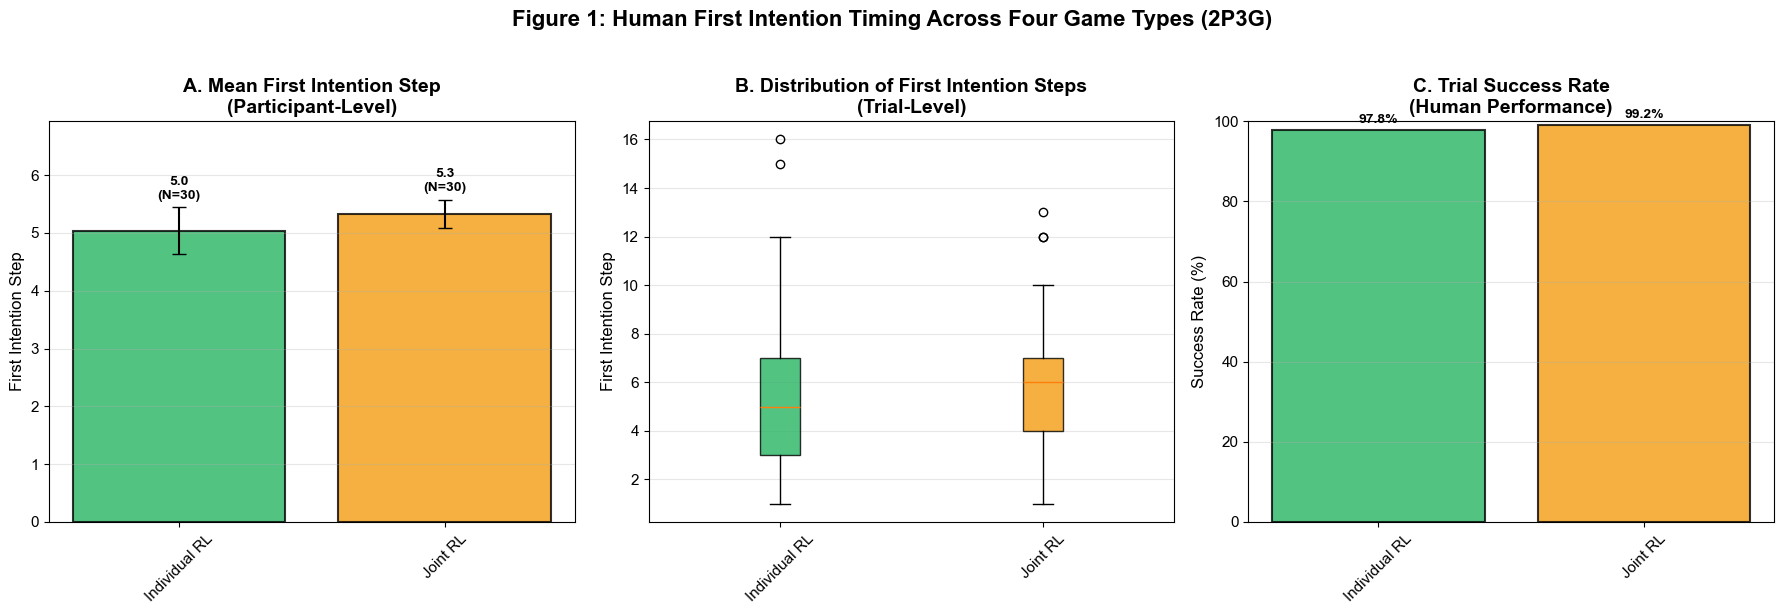


📊 Figure 1 Summary:
Human players analyzed: 720 instances
Unique participants: 60
Game types covered: 2


In [ ]:
# Create main Figure 1: Human players across four game types
if not first_intention_df.empty:
    # Filter to human players only
    human_data = first_intention_df[first_intention_df['player_type'] == 'human']

    if not human_data.empty:
        print(f"Figure 1 data: {len(human_data)} human instances across {human_data['game_type'].nunique()} game types")

        # Calculate participant-level means for human players
        human_participant_means = human_data.groupby(['participant_id', 'game_type'])['first_intention_step'].mean().reset_index()

        fig, axes = plt.subplots(1, 3, figsize=(18, 6))
        fig.suptitle('Figure 1: Human First Intention Timing Across Four Game Types (2P3G)',
                     fontsize=16, fontweight='bold', y=1.02)

        # Panel A: Bar plot with participant-level means
        available_types = [gt for gt in game_type_order if gt in human_participant_means['game_type'].values]
        available_labels = [game_type_labels[game_type_order.index(gt)] for gt in available_types]
        available_colors = [CONDITION_COLORS[gt] for gt in available_types]

        plot_data, plot_errors, plot_ns = [], [], []
        for game_type in available_types:
            subset = human_participant_means[human_participant_means['game_type'] == game_type]['first_intention_step']
            if len(subset) > 0:
                plot_data.append(subset.mean())
                plot_errors.append(subset.std() / np.sqrt(len(subset)))  # SEM
                plot_ns.append(len(subset))
            else:
                plot_data.append(0)
                plot_errors.append(0)
                plot_ns.append(0)

        bars = axes[0].bar(available_labels, plot_data, yerr=plot_errors, capsize=5,
                          alpha=0.8, color=available_colors, edgecolor='black', linewidth=1.5)

        # Add value labels on bars
        for bar, mean_val, error_val, n in zip(bars, plot_data, plot_errors, plot_ns):
            if n > 0:
                axes[0].text(bar.get_x() + bar.get_width()/2., mean_val + error_val + 0.1,
                            f'{mean_val:.1f}\n(N={n})', ha='center', va='bottom',
                            fontweight='bold', fontsize=10)

        axes[0].set_title('A. Mean First Intention Step\n(Participant-Level)', fontweight='bold')
        axes[0].set_ylabel('First Intention Step')
        axes[0].tick_params(axis='x', rotation=45)
        axes[0].grid(True, alpha=0.3, axis='y')
        axes[0].set_ylim(0, max(plot_data) * 1.3 if max(plot_data) > 0 else 10)

        # Panel B: Box plot showing distributions
        game_type_data = []
        game_type_labels_plot = []
        for game_type in available_types:
            subset = human_data[human_data['game_type'] == game_type]['first_intention_step']
            if len(subset) > 0:
                game_type_data.append(subset.values)
                idx = available_types.index(game_type)
                game_type_labels_plot.append(available_labels[idx])

        if game_type_data:
            bp = axes[1].boxplot(game_type_data, labels=game_type_labels_plot, patch_artist=True)
            for patch, color in zip(bp['boxes'], available_colors[:len(game_type_data)]):
                patch.set_facecolor(color)
                patch.set_alpha(0.8)
            axes[1].set_title('B. Distribution of First Intention Steps\n(Trial-Level)', fontweight='bold')
            axes[1].set_ylabel('First Intention Step')
            axes[1].tick_params(axis='x', rotation=45)
            axes[1].grid(True, alpha=0.3, axis='y')

        # Panel C: Success rate by game type
        if 'trial_success' in human_data.columns:
            success_data = []
            for game_type in available_types:
                subset = human_data[human_data['game_type'] == game_type]
                if len(subset) > 0:
                    success_rate = subset['trial_success'].mean() * 100
                    success_data.append(success_rate)
                else:
                    success_data.append(0)

            bars = axes[2].bar(available_labels, success_data, color=available_colors,
                              alpha=0.8, edgecolor='black', linewidth=1.5)

            # Add value labels
            for bar, success_rate in zip(bars, success_data):
                axes[2].text(bar.get_x() + bar.get_width()/2., success_rate + 1,
                            f'{success_rate:.1f}%', ha='center', va='bottom',
                            fontweight='bold', fontsize=10)

            axes[2].set_title('C. Trial Success Rate\n(Human Performance)', fontweight='bold')
            axes[2].set_ylabel('Success Rate (%)')
            axes[2].tick_params(axis='x', rotation=45)
            axes[2].set_ylim(0, 100)
            axes[2].grid(True, alpha=0.3, axis='y')

        plt.tight_layout()
        plt.savefig('merged_first_intention_analysis_humans.png', dpi=300, bbox_inches='tight')
        plt.show()

        print(f"\n📊 Figure 1 Summary:")
        print(f"Human players analyzed: {len(human_data)} instances")
        print(f"Unique participants: {human_data['participant_id'].nunique()}")
        print(f"Game types covered: {len(available_types)}")

    else:
        print("No human data available for Figure 1")
else:
    print("No data available for visualization")

## Figure 2: AI Players Across Three Game Types

Figure 2 data: 720 AI instances across 2 game types


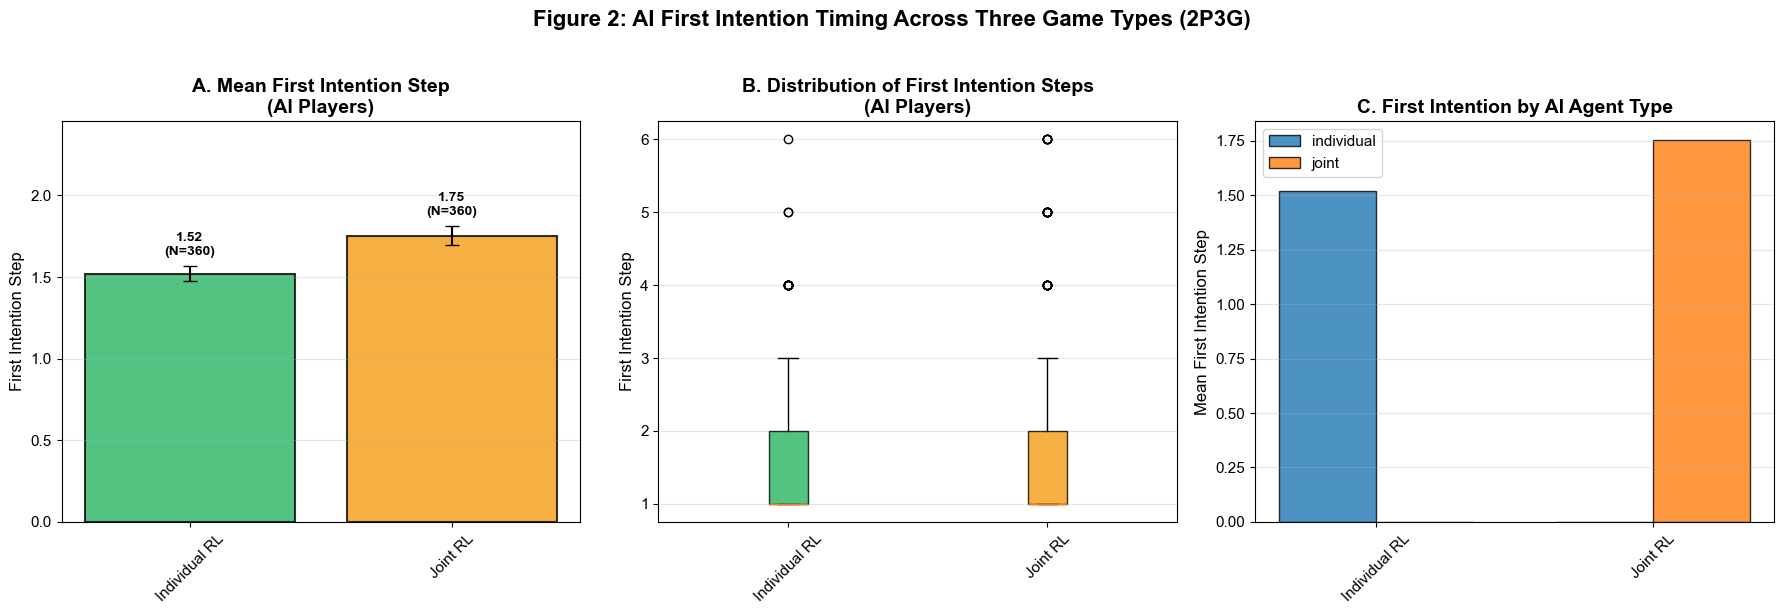


🤖 Figure 2 Summary:
AI players analyzed: 720 instances
Game types covered: 2
AI agent types: ['joint', 'individual']


In [ ]:
# Create main Figure 2: AI players across three game types
if not first_intention_df.empty:
    # Filter to AI players only
    ai_data = first_intention_df[first_intention_df['player_type'] == 'ai']

    if not ai_data.empty:
        print(f"Figure 2 data: {len(ai_data)} AI instances across {ai_data['game_type'].nunique()} game types")

        # AI game types (exclude human-only condition)
        ai_game_types = [gt for gt in ['gpt-4.1-mini', 'individual_rl', 'joint_rl']
                        if gt in ai_data['game_type'].values]
        ai_labels = [game_type_labels[game_type_order.index(gt)] for gt in ai_game_types]
        ai_colors = [CONDITION_COLORS[gt] for gt in ai_game_types]

        fig, axes = plt.subplots(1, 3, figsize=(18, 6))
        fig.suptitle('Figure 2: AI First Intention Timing Across Three Game Types (2P3G)',
                     fontsize=16, fontweight='bold', y=1.02)

        # Panel A: Bar plot with means
        ai_plot_data, ai_plot_errors, ai_plot_ns = [], [], []
        for game_type in ai_game_types:
            subset = ai_data[ai_data['game_type'] == game_type]['first_intention_step']
            if len(subset) > 0:
                ai_plot_data.append(subset.mean())
                ai_plot_errors.append(subset.std() / np.sqrt(len(subset)))  # SEM
                ai_plot_ns.append(len(subset))
            else:
                ai_plot_data.append(0)
                ai_plot_errors.append(0)
                ai_plot_ns.append(0)

        bars = axes[0].bar(ai_labels, ai_plot_data, yerr=ai_plot_errors, capsize=5,
                          alpha=0.8, color=ai_colors, edgecolor='black', linewidth=1.5)

        # Add value labels on bars
        for bar, mean_val, error_val, n in zip(bars, ai_plot_data, ai_plot_errors, ai_plot_ns):
            if n > 0:
                axes[0].text(bar.get_x() + bar.get_width()/2., mean_val + error_val + 0.05,
                            f'{mean_val:.2f}\n(N={n})', ha='center', va='bottom',
                            fontweight='bold', fontsize=10)

        axes[0].set_title('A. Mean First Intention Step\n(AI Players)', fontweight='bold')
        axes[0].set_ylabel('First Intention Step')
        axes[0].tick_params(axis='x', rotation=45)
        axes[0].grid(True, alpha=0.3, axis='y')
        axes[0].set_ylim(0, max(ai_plot_data) * 1.4 if max(ai_plot_data) > 0 else 5)

        # Panel B: Box plot showing distributions
        ai_box_data = []
        ai_box_labels = []
        for game_type in ai_game_types:
            subset = ai_data[ai_data['game_type'] == game_type]['first_intention_step']
            if len(subset) > 0:
                ai_box_data.append(subset.values)
                idx = ai_game_types.index(game_type)
                ai_box_labels.append(ai_labels[idx])

        if ai_box_data:
            bp = axes[1].boxplot(ai_box_data, labels=ai_box_labels, patch_artist=True)
            for patch, color in zip(bp['boxes'], ai_colors[:len(ai_box_data)]):
                patch.set_facecolor(color)
                patch.set_alpha(0.8)
            axes[1].set_title('B. Distribution of First Intention Steps\n(AI Players)', fontweight='bold')
            axes[1].set_ylabel('First Intention Step')
            axes[1].tick_params(axis='x', rotation=45)
            axes[1].grid(True, alpha=0.3, axis='y')

        # Panel C: Agent type comparison if available
        if 'agent_type' in ai_data.columns:
            agent_comparison = ai_data.groupby(['game_type', 'agent_type'])['first_intention_step'].agg(
                ['mean', 'count']
            ).reset_index()

            # Create a simple comparison plot
            unique_agents = agent_comparison['agent_type'].unique()
            x_pos = np.arange(len(ai_game_types))
            width = 0.35

            for i, agent in enumerate(unique_agents):
                agent_data = []
                for game_type in ai_game_types:
                    subset = agent_comparison[
                        (agent_comparison['game_type'] == game_type) &
                        (agent_comparison['agent_type'] == agent)
                    ]
                    if len(subset) > 0:
                        agent_data.append(subset['mean'].iloc[0])
                    else:
                        agent_data.append(0)

                offset = (i - len(unique_agents)/2 + 0.5) * width
                axes[2].bar(x_pos + offset, agent_data, width,
                           label=agent, alpha=0.8, edgecolor='black', linewidth=1)

            axes[2].set_title('C. First Intention by AI Agent Type', fontweight='bold')
            axes[2].set_ylabel('Mean First Intention Step')
            axes[2].set_xticks(x_pos)
            axes[2].set_xticklabels(ai_labels, rotation=45)
            axes[2].legend()
            axes[2].grid(True, alpha=0.3, axis='y')

        plt.tight_layout()
        plt.savefig('merged_first_intention_analysis_ai.png', dpi=300, bbox_inches='tight')
        plt.show()

        print(f"\n🤖 Figure 2 Summary:")
        print(f"AI players analyzed: {len(ai_data)} instances")
        print(f"Game types covered: {len(ai_game_types)}")
        if 'agent_type' in ai_data.columns:
            print(f"AI agent types: {list(ai_data['agent_type'].unique())}")

    else:
        print("No AI data available for Figure 2")
else:
    print("No data available for visualization")

## Statistical Analysis

In [ ]:
from scipy import stats
from itertools import combinations

if not first_intention_df.empty:
    print("STATISTICAL ANALYSIS: MERGED FIRST INTENTION PATTERNS")
    print("=" * 60)

    # 1. Human players across four game types
    human_data = first_intention_df[first_intention_df['player_type'] == 'human']

    if not human_data.empty:
        print("\n1️⃣ HUMAN PLAYERS ACROSS GAME TYPES")
        print("-" * 40)

        # Calculate participant-level means for humans
        human_participant_means = human_data.groupby(['participant_id', 'game_type'])['first_intention_step'].mean().reset_index()

        available_types = [gt for gt in game_type_order if gt in human_participant_means['game_type'].values]

        print(f"\nHuman first intention timing by game type:")
        for game_type in available_types:
            subset = human_participant_means[human_participant_means['game_type'] == game_type]['first_intention_step']
            label = game_type_labels[game_type_order.index(game_type)]
            print(f"  {label}: {subset.mean():.2f} ± {subset.std():.2f} steps (N={len(subset)} participants)")

        # One-way ANOVA across game types for human players
        if len(available_types) >= 2:
            human_groups = []
            for game_type in available_types:
                subset = human_participant_means[human_participant_means['game_type'] == game_type]['first_intention_step']
                human_groups.append(subset.values)

            f_stat, p_value = stats.f_oneway(*human_groups)
            print(f"\nOne-way ANOVA across game types (human players):")
            print(f"F-statistic: {f_stat:.3f}, p-value: {p_value:.4f}")

            if p_value < 0.05:
                print("→ Significant differences between game types")

                # Post-hoc pairwise comparisons
                print(f"\nPairwise comparisons (human players):")
                for gt1, gt2 in combinations(available_types, 2):
                    data1 = human_participant_means[human_participant_means['game_type'] == gt1]['first_intention_step']
                    data2 = human_participant_means[human_participant_means['game_type'] == gt2]['first_intention_step']

                    if len(data1) > 0 and len(data2) > 0:
                        t_stat, t_p = stats.ttest_ind(data1, data2)
                        label1 = game_type_labels[game_type_order.index(gt1)]
                        label2 = game_type_labels[game_type_order.index(gt2)]
                        print(f"  {label1} vs {label2}: t={t_stat:.3f}, p={t_p:.4f}")
            else:
                print("→ No significant differences between game types")

    # 2. AI players across three game types
    ai_data = first_intention_df[first_intention_df['player_type'] == 'ai']

    if not ai_data.empty:
        print("\n\n2️⃣ AI PLAYERS ACROSS GAME TYPES")
        print("-" * 40)

        ai_game_types = [gt for gt in ['gpt-4.1-mini', 'individual_rl', 'joint_rl']
                        if gt in ai_data['game_type'].values]

        print(f"\nAI first intention timing by game type:")
        for game_type in ai_game_types:
            subset = ai_data[ai_data['game_type'] == game_type]['first_intention_step']
            label = game_type_labels[game_type_order.index(game_type)]
            print(f"  {label}: {subset.mean():.2f} ± {subset.std():.2f} steps (N={len(subset)} instances)")

        # One-way ANOVA across game types for AI players
        if len(ai_game_types) >= 2:
            ai_groups = []
            for game_type in ai_game_types:
                subset = ai_data[ai_data['game_type'] == game_type]['first_intention_step']
                ai_groups.append(subset.values)

            f_stat, p_value = stats.f_oneway(*ai_groups)
            print(f"\nOne-way ANOVA across game types (AI players):")
            print(f"F-statistic: {f_stat:.3f}, p-value: {p_value:.4f}")

            if p_value < 0.05:
                print("→ Significant differences between AI game types")

                # Post-hoc pairwise comparisons
                print(f"\nPairwise comparisons (AI players):")
                for gt1, gt2 in combinations(ai_game_types, 2):
                    data1 = ai_data[ai_data['game_type'] == gt1]['first_intention_step']
                    data2 = ai_data[ai_data['game_type'] == gt2]['first_intention_step']

                    if len(data1) > 0 and len(data2) > 0:
                        t_stat, t_p = stats.ttest_ind(data1, data2)
                        label1 = game_type_labels[game_type_order.index(gt1)]
                        label2 = game_type_labels[game_type_order.index(gt2)]
                        print(f"  {label1} vs {label2}: t={t_stat:.3f}, p={t_p:.4f}")
            else:
                print("→ No significant differences between AI game types")

    # 3. Overall Human vs AI comparison
    if 'ai' in first_intention_df['player_type'].values and 'human' in first_intention_df['player_type'].values:
        print("\n\n3️⃣ OVERALL HUMAN vs AI COMPARISON")
        print("-" * 40)

        human_timing = first_intention_df[first_intention_df['player_type'] == 'human']['first_intention_step']
        ai_timing = first_intention_df[first_intention_df['player_type'] == 'ai']['first_intention_step']

        # Mann-Whitney U test for human vs AI
        statistic, p_value = stats.mannwhitneyu(human_timing, ai_timing, alternative='two-sided')
        print(f"\nOverall Human vs AI first intention timing:")
        print(f"Human: {human_timing.mean():.2f} ± {human_timing.std():.2f} (n={len(human_timing)})")
        print(f"AI: {ai_timing.mean():.2f} ± {ai_timing.std():.2f} (n={len(ai_timing)})")
        print(f"Mann-Whitney U: {statistic:.2f}, p-value: {p_value:.4f}")

        if p_value < 0.05:
            if human_timing.mean() > ai_timing.mean():
                diff = human_timing.mean() - ai_timing.mean()
                print(f"→ Humans take significantly longer to form first intentions (+{diff:.1f} steps)")
            else:
                diff = ai_timing.mean() - human_timing.mean()
                print(f"→ AI takes significantly longer to form first intentions (+{diff:.1f} steps)")
        else:
            print("→ No significant difference between human and AI first intention timing")

        # Game-type specific human vs AI comparisons
        common_game_types = [gt for gt in game_type_order
                           if gt in human_data['game_type'].values and gt in ai_data['game_type'].values]

        if common_game_types:
            print(f"\nGame-type specific Human vs AI comparisons:")
            for game_type in common_game_types:
                human_game = human_data[human_data['game_type'] == game_type]['first_intention_step']
                ai_game = ai_data[ai_data['game_type'] == game_type]['first_intention_step']

                if len(human_game) > 0 and len(ai_game) > 0:
                    stat, p_val = stats.mannwhitneyu(human_game, ai_game, alternative='two-sided')
                    label = game_type_labels[game_type_order.index(game_type)]
                    print(f"  {label}:")
                    print(f"    Human: {human_game.mean():.2f} ± {human_game.std():.2f} (n={len(human_game)})")
                    print(f"    AI: {ai_game.mean():.2f} ± {ai_game.std():.2f} (n={len(ai_game)})")
                    print(f"    U={stat:.2f}, p={p_val:.4f}")

    print(f"\n\n📊 ANALYSIS SUMMARY")
    print("=" * 30)
    total_instances = len(first_intention_df)
    human_instances = len(first_intention_df[first_intention_df['player_type'] == 'human'])
    ai_instances = len(first_intention_df[first_intention_df['player_type'] == 'ai'])

    print(f"• Total first intention instances: {total_instances}")
    print(f"• Human instances: {human_instances}")
    print(f"• AI instances: {ai_instances}")
    print(f"• Game types analyzed: {sorted(first_intention_df['game_type'].unique())}")
    print(f"• Studies included: {sorted(first_intention_df['study'].unique())}")
    print(f"• Focus: 2P3G trials only")

else:
    print("No data available for statistical analysis")

STATISTICAL ANALYSIS: MERGED FIRST INTENTION PATTERNS

1️⃣ HUMAN PLAYERS ACROSS GAME TYPES
----------------------------------------

Human first intention timing by game type:
  Individual RL: 5.04 ± 2.23 steps (N=30 participants)
  Joint RL: 5.33 ± 1.34 steps (N=30 participants)

One-way ANOVA across game types (human players):
F-statistic: 0.391, p-value: 0.5342
→ No significant differences between game types


2️⃣ AI PLAYERS ACROSS GAME TYPES
----------------------------------------

AI first intention timing by game type:
  Individual RL: 1.52 ± 0.86 steps (N=360 instances)
  Joint RL: 1.75 ± 1.08 steps (N=360 instances)

One-way ANOVA across game types (AI players):
F-statistic: 10.244, p-value: 0.0014
→ Significant differences between AI game types

Pairwise comparisons (AI players):
  Individual RL vs Joint RL: t=-3.201, p=0.0014


3️⃣ OVERALL HUMAN vs AI COMPARISON
----------------------------------------

Overall Human vs AI first intention timing:
Human: 5.18 ± 2.51 (n=720)
A

## Summary and Insights

In [ ]:
if not first_intention_df.empty:
    print("🎯 MERGED FIRST INTENTION ANALYSIS: KEY INSIGHTS")
    print("=" * 55)

    # Data overview
    print(f"\n📊 DATA OVERVIEW:")
    print(f"• Total instances analyzed: {len(first_intention_df)}")
    print(f"• Unique participants: {first_intention_df['participant_id'].nunique()}")
    print(f"• Studies: {', '.join(first_intention_df['study'].unique())}")
    print(f"• Game types: {', '.join(sorted(first_intention_df['game_type'].unique()))}")
    print(f"• Focus: 2P3G collaborative trials only")

    # Key findings for humans
    human_data = first_intention_df[first_intention_df['player_type'] == 'human']
    if not human_data.empty:
        print(f"\n👤 HUMAN FIRST INTENTION PATTERNS:")
        human_participant_means = human_data.groupby(['participant_id', 'game_type'])['first_intention_step'].mean().reset_index()

        for game_type in game_type_order:
            if game_type in human_participant_means['game_type'].values:
                subset = human_participant_means[human_participant_means['game_type'] == game_type]['first_intention_step']
                label = game_type_labels[game_type_order.index(game_type)]
                print(f"• {label}: {subset.mean():.1f} ± {subset.std():.1f} steps (N={len(subset)} participants)")

    # Key findings for AI
    ai_data = first_intention_df[first_intention_df['player_type'] == 'ai']
    if not ai_data.empty:
        print(f"\n🤖 AI FIRST INTENTION PATTERNS:")
        ai_game_types = [gt for gt in ['gpt-4.1-mini', 'individual_rl', 'joint_rl']
                        if gt in ai_data['game_type'].values]

        for game_type in ai_game_types:
            subset = ai_data[ai_data['game_type'] == game_type]['first_intention_step']
            label = game_type_labels[game_type_order.index(game_type)]
            print(f"• {label}: {subset.mean():.2f} ± {subset.std():.2f} steps (N={len(subset)} instances)")

    # Overall comparison
    if not human_data.empty and not ai_data.empty:
        print(f"\n⚡ HUMAN vs AI COMPARISON:")
        human_overall = human_data['first_intention_step'].mean()
        ai_overall = ai_data['first_intention_step'].mean()
        print(f"• Human average: {human_overall:.1f} steps")
        print(f"• AI average: {ai_overall:.1f} steps")

        if human_overall > ai_overall:
            diff = human_overall - ai_overall
            print(f"• Humans take {diff:.1f} steps longer on average to form first intentions")
        else:
            diff = ai_overall - human_overall
            print(f"• AI takes {diff:.1f} steps longer on average to form first intentions")

    # Success rates
    if 'trial_success' in first_intention_df.columns:
        print(f"\n🎯 SUCCESS RATES BY GAME TYPE:")
        success_by_game = first_intention_df.groupby('game_type')['trial_success'].mean() * 100
        for game_type in game_type_order:
            if game_type in success_by_game.index:
                success_rate = success_by_game[game_type]
                label = game_type_labels[game_type_order.index(game_type)]
                print(f"• {label}: {success_rate:.1f}% success rate")

    # Study-specific insights
    print(f"\n📚 STUDY-SPECIFIC INSIGHTS:")
    study_breakdown = first_intention_df.groupby(['study', 'player_type']).size().unstack(fill_value=0)
    for study in first_intention_df['study'].unique():
        study_data = first_intention_df[first_intention_df['study'] == study]
        human_count = len(study_data[study_data['player_type'] == 'human'])
        ai_count = len(study_data[study_data['player_type'] == 'ai'])
        game_types = ', '.join(sorted(study_data['game_type'].unique()))
        print(f"• {study}: {human_count} human + {ai_count} AI instances across {game_types}")

    print(f"\n✅ Analysis complete! Figures saved as:")
    print(f"• merged_first_intention_analysis_humans.png (Figure 1)")
    print(f"• merged_first_intention_analysis_ai.png (Figure 2)")

else:
    print("No data available for summary")

🎯 MERGED FIRST INTENTION ANALYSIS: KEY INSIGHTS

📊 DATA OVERVIEW:
• Total instances analyzed: 1440
• Unique participants: 60
• Studies: Human-RL
• Game types: individual_rl, joint_rl
• Focus: 2P3G collaborative trials only

👤 HUMAN FIRST INTENTION PATTERNS:
• Individual RL: 5.0 ± 2.2 steps (N=30 participants)
• Joint RL: 5.3 ± 1.3 steps (N=30 participants)

🤖 AI FIRST INTENTION PATTERNS:
• Individual RL: 1.52 ± 0.86 steps (N=360 instances)
• Joint RL: 1.75 ± 1.08 steps (N=360 instances)

⚡ HUMAN vs AI COMPARISON:
• Human average: 5.2 steps
• AI average: 1.6 steps
• Humans take 3.5 steps longer on average to form first intentions

🎯 SUCCESS RATES BY GAME TYPE:
• Individual RL: 97.8% success rate
• Joint RL: 99.2% success rate

📚 STUDY-SPECIFIC INSIGHTS:
• Human-RL: 720 human + 720 AI instances across individual_rl, joint_rl

✅ Analysis complete! Figures saved as:
• merged_first_intention_analysis_humans.png (Figure 1)
• merged_first_intention_analysis_ai.png (Figure 2)
